In [1]:
%load_ext nb_black
%load_ext autoreload

%autoreload 2

<IPython.core.display.Javascript object>

In [2]:
import os
from pathlib import Path

from requests import get
import pandas as pd
import numpy as np

from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

import logging

logging.basicConfig(level=logging.WARN)

<IPython.core.display.Javascript object>

In [3]:
from xplainet.input_utils import preproc_dataset
from xplainet.model import build_model
from xplainet.random_utils import setup_seed, SEED
from sklearn.model_selection import ShuffleSplit

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

%matplotlib inline

from zipfile import ZipFile

<IPython.core.display.Javascript object>

In [4]:
!pip install keras-tuner

You should consider upgrading via the '/work/.cache/poetry/xplainet-KS9Ipbc1-py3.7/bin/python -m pip install --upgrade pip' command.


<IPython.core.display.Javascript object>

In [5]:
from kerastuner.tuners import RandomSearch, Hyperband
from kerastuner.engine.hypermodel import HyperModel
from kerastuner.engine.hyperparameters import HyperParameters

<IPython.core.display.Javascript object>

In [6]:
setup_seed()

<IPython.core.display.Javascript object>

In [7]:
def download(url, out, force=False, verify=True):
    out.parent.mkdir(parents=True, exist_ok=True)
    if force and out.exists():
        print(f"Removing file at {str(out)}")
        out.unlink()

    if out.exists():
        print("File already exists.")
        return
    print(f"Downloading {url} at {str(out)} ...")
    # open in binary mode
    with out.open(mode="wb") as file:
        # get request
        response = get(url, verify=verify)
        for chunk in response.iter_content(100000):
            # write to file
            file.write(chunk)


<IPython.core.display.Javascript object>

In [8]:
def plot_history(history):
    loss_list = [s for s in history.history.keys() if "loss" in s and "val" not in s]
    val_loss_list = [s for s in history.history.keys() if "loss" in s and "val" in s]
    acc_list = [s for s in history.history.keys() if "AUC" in s and "val" not in s]
    val_acc_list = [s for s in history.history.keys() if "AUC" in s and "val" in s]

    if len(loss_list) == 0:
        print("Loss is missing in history")
        return

    ## As loss always exists
    epochs = range(1, len(history.history[loss_list[0]]) + 1)

    ## Loss
    plt.figure(1)
    for l in loss_list:
        plt.plot(
            epochs,
            history.history[l],
            "b",
            label="Training loss ("
            + str(str(format(history.history[l][-1], ".5f")) + ")"),
        )
    for l in val_loss_list:
        plt.plot(
            epochs,
            history.history[l],
            "g",
            label="Validation loss ("
            + str(str(format(history.history[l][-1], ".5f")) + ")"),
        )

    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

<IPython.core.display.Javascript object>

## House prices : loading data

In [9]:
dataset_name = "kaggle-house-prices"
out = Path(os.getcwd() + "/data/" + dataset_name + "-train.csv")

target = "SalePrice"
to_remove = []
train = pd.read_csv(out, sep=",", low_memory=False)

<IPython.core.display.Javascript object>

In [10]:
if "Set" not in train.columns:
    print("Building tailored column")
    train_valid_index, test_index = next(
        ShuffleSplit(n_splits=1, test_size=0.1, random_state=SEED).split(
            range(train[target].shape[0])
        )
    )
    train_index, valid_index = next(
        ShuffleSplit(n_splits=1, test_size=0.1, random_state=SEED).split(
            train_valid_index
        )
    )
    train["Set"] = "train"
    train["Set"][valid_index] = "valid"
    train["Set"][test_index] = "test"
    # train.to_csv((out.parent / "train_bench.csv").as_posix(), index=False)

Building tailored column


/work/.cache/poetry/xplainet-KS9Ipbc1-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/work/.cache/poetry/xplainet-KS9Ipbc1-py3.7/lib/python3.7/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/work/.cache/poetry/xplainet-KS9Ipbc1-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexin

<IPython.core.display.Javascript object>

In [11]:
train_indices = train[train.Set == "train"].index
valid_indices = train[train.Set == "valid"].index
test_indices = train[train.Set == "test"].index

<IPython.core.display.Javascript object>

In [12]:
input_train, params = preproc_dataset(train.loc[train_indices], target, ["Set"])
params

{'constant_cols': [],
 'bool_cols': ['Street', 'Alley', 'Utilities', 'CentralAir'],
 'num_cols': ['1stFlrSF',
  'BsmtUnfSF',
  'YearRemodAdd',
  'BsmtFinSF2',
  'OpenPorchSF',
  'GarageYrBlt',
  'GrLivArea',
  'Id',
  'LotFrontage',
  'GarageArea',
  'LotArea',
  'YearBuilt',
  'BsmtFinSF1',
  'ScreenPorch',
  'MasVnrArea',
  'WoodDeckSF',
  '2ndFlrSF',
  'TotalBsmtSF',
  'EnclosedPorch'],
 'cat_cols': ['SaleType',
  'MasVnrType',
  'YrSold',
  'BsmtHalfBath',
  'BedroomAbvGr',
  'GarageType',
  'GarageFinish',
  'Foundation',
  'HouseStyle',
  'OverallQual',
  'BsmtFinType1',
  'FullBath',
  'Fireplaces',
  'Condition2',
  'Fence',
  'HeatingQC',
  'LotShape',
  'MSZoning',
  'Exterior1st',
  'BsmtExposure',
  'Condition1',
  'LandContour',
  'Functional',
  'Heating',
  'GarageCond',
  'SaleCondition',
  'ExterCond',
  'HalfBath',
  'KitchenAbvGr',
  'LandSlope',
  'Exterior2nd',
  'MSSubClass',
  'TotRmsAbvGrd',
  'PoolQC',
  'OverallCond',
  'RoofMatl',
  'GarageQual',
  'RoofStyle

<IPython.core.display.Javascript object>

In [13]:
len(train_indices)

1219

<IPython.core.display.Javascript object>

In [14]:
input_valid, _ = preproc_dataset(train.loc[valid_indices], target, ["Set"], params)
input_test, _ = preproc_dataset(train.loc[test_indices], target, ["Set"], params)

<IPython.core.display.Javascript object>

In [15]:
target_encoder = StandardScaler()

<IPython.core.display.Javascript object>

In [16]:
target_encoder.fit(train[target].values.reshape(-1, 1))
y_train = target_encoder.transform(train[target].values[train_indices].reshape(-1, 1))
y_valid = target_encoder.transform(train[target].values[valid_indices].reshape(-1, 1))
y_test = target_encoder.transform(train[target].values[test_indices].reshape(-1, 1))

<IPython.core.display.Javascript object>

In [17]:
params

{'constant_cols': [],
 'bool_cols': ['Street', 'Alley', 'Utilities', 'CentralAir'],
 'num_cols': ['1stFlrSF',
  'BsmtUnfSF',
  'YearRemodAdd',
  'BsmtFinSF2',
  'OpenPorchSF',
  'GarageYrBlt',
  'GrLivArea',
  'Id',
  'LotFrontage',
  'GarageArea',
  'LotArea',
  'YearBuilt',
  'BsmtFinSF1',
  'ScreenPorch',
  'MasVnrArea',
  'WoodDeckSF',
  '2ndFlrSF',
  'TotalBsmtSF',
  'EnclosedPorch'],
 'cat_cols': ['SaleType',
  'MasVnrType',
  'YrSold',
  'BsmtHalfBath',
  'BedroomAbvGr',
  'GarageType',
  'GarageFinish',
  'Foundation',
  'HouseStyle',
  'OverallQual',
  'BsmtFinType1',
  'FullBath',
  'Fireplaces',
  'Condition2',
  'Fence',
  'HeatingQC',
  'LotShape',
  'MSZoning',
  'Exterior1st',
  'BsmtExposure',
  'Condition1',
  'LandContour',
  'Functional',
  'Heating',
  'GarageCond',
  'SaleCondition',
  'ExterCond',
  'HalfBath',
  'KitchenAbvGr',
  'LandSlope',
  'Exterior2nd',
  'MSSubClass',
  'TotRmsAbvGrd',
  'PoolQC',
  'OverallCond',
  'RoofMatl',
  'GarageQual',
  'RoofStyle

<IPython.core.display.Javascript object>

In [18]:
def build_model_tuner_builder(params):
    def build_model_tuner(hp):
        lconv_dim_list = []
        emb_size = 4
        if len(params["cat_cols"]) > 0:
            for i in range(hp.Int("num_layers_cat", 1, 2, default=1)):
                dim = hp.Int("units_cat_" + str(i), 1, 5, 1, default=2)
                lconv_dim_list.append(int(2 ** dim))
            emb_size = hp.Int("emb_size", 1, 8, 1, default=4)

        lconv_num_dim_list = []
        activation_num_first_layer = None
        if len(params["num_cols"]) > 0:
            for i in range(hp.Int("num_layers_num", 1, 2, default=1)):
                dim = hp.Int("units_num_" + str(i), 1, 6, 1, default=3)
                lconv_num_dim_list.append(int(2 ** dim))
            activation_num_first_layer = hp.Choice(
                "activation_num_first_layer", ["None", "tanh"], default="None"
            )
            if activation_num_first_layer == "None":
                activation_num_first_layer = None

        #         output_activation=  hp.Choice(
        #             "output_activation", ["sigmoid", "softmax"], default="sigmoid"
        #         )
        output_activation = None
        output_dim = 1  # if output_activation == "sigmoid" else 2
        emb_size = int(2 ** emb_size)

        return build_model(
            params,
            lconv_dim=lconv_dim_list,
            lconv_num_dim=lconv_num_dim_list,
            emb_size=emb_size,
            activation_num_first_layer=activation_num_first_layer,  # "tanh",
            output_dim=output_dim,
            output_activation=output_activation,
        )

    return build_model_tuner

<IPython.core.display.Javascript object>

In [19]:
import shutil

shutil.rmtree("test_dir", ignore_errors=True)

<IPython.core.display.Javascript object>

In [20]:
class MyTuner(RandomSearch):
    def run_trial(self, trial, *args, **kwargs):
        # You can add additional HyperParameters for preprocessing and custom training loops
        # via overriding `run_trial`
        #         kwargs["batch_size"] = int(
        #             2 ** trial.hyperparameters.Int("batch_size", 3, 13, step=1)
        #         )
        super(MyTuner, self).run_trial(trial, *args, **kwargs)

<IPython.core.display.Javascript object>

In [21]:
tuner = MyTuner(
    build_model_tuner_builder(params),
    objective="val_loss",
    max_trials=30,
    executions_per_trial=1,
    directory="test_dir",
)

/work/.cache/poetry/xplainet-KS9Ipbc1-py3.7/lib/python3.7/site-packages/tensorflow_addons/utils/resource_loader.py:103: UserWarning: You are currently using TensorFlow 2.3.0 and trying to load a custom op (custom_ops/activations/_activation_ops.so).
TensorFlow Addons has compiled its custom ops against TensorFlow 2.2.0, and there are no compatibility guarantees between the two versions. 
This means that you might get segfaults when loading the custom op, or other kind of low-level errors.
 If you do, do not file an issue on Github. This is a known limitation.

It might help you to fallback to pure Python ops with TF_ADDONS_PY_OPS . To do that, see https://github.com/tensorflow/addons#gpucpu-custom-ops 

You can also change the TensorFlow version installed on your system. You would need a TensorFlow version equal to or above 2.2.0 and strictly below 2.3.0.
 Note that nightly versions of TensorFlow, as well as non-pip TensorFlow like `conda install tensorflow` or compiled from source are

<IPython.core.display.Javascript object>

In [22]:
tuner.search_space_summary()

<IPython.core.display.Javascript object>

In [23]:
counts = np.unique(y_train, return_counts=True)[1]
counts = counts.sum() / counts

<IPython.core.display.Javascript object>

In [24]:
class_weight = {
    0: counts[0],
    1: counts[1],
}
class_weight

{0: 1219.0, 1: 1219.0}

<IPython.core.display.Javascript object>

In [25]:
tuner.search(
    input_train,
    y_train.reshape(-1, 1),
    epochs=50,
    batch_size=8,
    validation_data=(
        input_valid,
        y_valid.reshape(-1, 1),
    ),
    verbose=2,
    callbacks=[EarlyStopping(monitor="val_loss", patience=3, verbose=1)],
    # class_weight=class_weight,
)

Epoch 1/50
153/153 - 1s - loss: 0.9528 - val_loss: 1.0274
Epoch 2/50
153/153 - 0s - loss: 0.8573 - val_loss: 0.8436
Epoch 3/50
153/153 - 0s - loss: 0.5621 - val_loss: 0.4242
Epoch 4/50
153/153 - 0s - loss: 0.2854 - val_loss: 0.3615
Epoch 5/50
153/153 - 0s - loss: 0.2118 - val_loss: 0.3697
Epoch 6/50
153/153 - 0s - loss: 0.1762 - val_loss: 0.3853
Epoch 7/50
153/153 - 0s - loss: 0.1561 - val_loss: 0.3927
Epoch 00007: early stopping


Epoch 1/50
153/153 - 1s - loss: 0.9445 - val_loss: 0.8782
Epoch 2/50
153/153 - 0s - loss: 0.5798 - val_loss: 0.3914
Epoch 3/50
153/153 - 1s - loss: 0.2566 - val_loss: 0.3568
Epoch 4/50
153/153 - 0s - loss: 0.1763 - val_loss: 0.3907
Epoch 5/50
153/153 - 0s - loss: 0.1405 - val_loss: 0.4092
Epoch 6/50
153/153 - 0s - loss: 0.1242 - val_loss: 0.4337
Epoch 00006: early stopping


Epoch 1/50
153/153 - 0s - loss: 0.9616 - val_loss: 0.9581
Epoch 2/50
153/153 - 0s - loss: 0.6995 - val_loss: 0.5027
Epoch 3/50
153/153 - 0s - loss: 0.3459 - val_loss: 0.2925
Epoch 4/50
153/153 - 0s - loss: 0.2358 - val_loss: 0.2588
Epoch 5/50
153/153 - 0s - loss: 0.1792 - val_loss: 0.2637
Epoch 6/50
153/153 - 0s - loss: 0.1489 - val_loss: 0.2841
Epoch 7/50
153/153 - 0s - loss: 0.1332 - val_loss: 0.3018
Epoch 00007: early stopping


Epoch 1/50
153/153 - 0s - loss: 0.9277 - val_loss: 0.9775
Epoch 2/50
153/153 - 0s - loss: 0.7856 - val_loss: 0.6410
Epoch 3/50
153/153 - 0s - loss: 0.4209 - val_loss: 0.3174
Epoch 4/50
153/153 - 0s - loss: 0.2718 - val_loss: 0.2870
Epoch 5/50
153/153 - 0s - loss: 0.2042 - val_loss: 0.3050
Epoch 6/50
153/153 - 0s - loss: 0.1662 - val_loss: 0.3479
Epoch 7/50
153/153 - 0s - loss: 0.1460 - val_loss: 0.3889
Epoch 00007: early stopping


Epoch 1/50
153/153 - 2s - loss: 0.7370 - val_loss: 0.3883
Epoch 2/50
153/153 - 1s - loss: 0.2381 - val_loss: 0.3403
Epoch 3/50
153/153 - 1s - loss: 0.1397 - val_loss: 0.4220
Epoch 4/50
153/153 - 1s - loss: 0.1180 - val_loss: 0.4169
Epoch 5/50
153/153 - 1s - loss: 0.1096 - val_loss: 0.4186
Epoch 00005: early stopping


Epoch 1/50
153/153 - 1s - loss: 0.9045 - val_loss: 0.8814
Epoch 2/50
153/153 - 1s - loss: 0.5823 - val_loss: 0.3810
Epoch 3/50
153/153 - 1s - loss: 0.2578 - val_loss: 0.3037
Epoch 4/50
153/153 - 1s - loss: 0.1756 - val_loss: 0.3422
Epoch 5/50
153/153 - 1s - loss: 0.1412 - val_loss: 0.3615
Epoch 6/50
153/153 - 1s - loss: 0.1253 - val_loss: 0.3839
Epoch 00006: early stopping


Epoch 1/50
153/153 - 1s - loss: 0.9124 - val_loss: 0.9265
Epoch 2/50
153/153 - 0s - loss: 0.7176 - val_loss: 0.5526
Epoch 3/50
153/153 - 0s - loss: 0.3660 - val_loss: 0.2833
Epoch 4/50
153/153 - 0s - loss: 0.2325 - val_loss: 0.2525
Epoch 5/50
153/153 - 0s - loss: 0.1741 - val_loss: 0.2518
Epoch 6/50
153/153 - 0s - loss: 0.1442 - val_loss: 0.2645
Epoch 7/50
153/153 - 0s - loss: 0.1304 - val_loss: 0.2702
Epoch 8/50
153/153 - 0s - loss: 0.1189 - val_loss: 0.2721
Epoch 00008: early stopping


Epoch 1/50
153/153 - 1s - loss: 0.8617 - val_loss: 0.8501
Epoch 2/50
153/153 - 0s - loss: 0.6729 - val_loss: 0.5778
Epoch 3/50
153/153 - 0s - loss: 0.3410 - val_loss: 0.3710
Epoch 4/50
153/153 - 0s - loss: 0.2133 - val_loss: 0.4066
Epoch 5/50
153/153 - 0s - loss: 0.1716 - val_loss: 0.4360
Epoch 6/50
153/153 - 0s - loss: 0.1483 - val_loss: 0.4786
Epoch 00006: early stopping


Epoch 1/50
153/153 - 0s - loss: 0.7746 - val_loss: 0.6732
Epoch 2/50
153/153 - 0s - loss: 0.4567 - val_loss: 0.4876
Epoch 3/50
153/153 - 0s - loss: 0.2619 - val_loss: 0.5609
Epoch 4/50
153/153 - 0s - loss: 0.2070 - val_loss: 0.6273
Epoch 5/50
153/153 - 0s - loss: 0.1834 - val_loss: 0.6237
Epoch 00005: early stopping


Epoch 1/50
153/153 - 1s - loss: 0.8840 - val_loss: 0.8857
Epoch 2/50
153/153 - 1s - loss: 0.5606 - val_loss: 0.3048
Epoch 3/50
153/153 - 1s - loss: 0.2681 - val_loss: 0.2021
Epoch 4/50
153/153 - 1s - loss: 0.1854 - val_loss: 0.1821
Epoch 5/50
153/153 - 1s - loss: 0.1528 - val_loss: 0.1819
Epoch 6/50
153/153 - 1s - loss: 0.1358 - val_loss: 0.1935
Epoch 7/50
153/153 - 1s - loss: 0.1257 - val_loss: 0.1951
Epoch 8/50
153/153 - 1s - loss: 0.1149 - val_loss: 0.2051
Epoch 00008: early stopping


Epoch 1/50
153/153 - 1s - loss: 0.9509 - val_loss: 0.9848
Epoch 2/50
153/153 - 0s - loss: 0.8658 - val_loss: 0.8626
Epoch 3/50
153/153 - 0s - loss: 0.7164 - val_loss: 0.6386
Epoch 4/50
153/153 - 0s - loss: 0.4712 - val_loss: 0.3983
Epoch 5/50
153/153 - 0s - loss: 0.3143 - val_loss: 0.3561
Epoch 6/50
153/153 - 0s - loss: 0.2602 - val_loss: 0.3566
Epoch 7/50
153/153 - 0s - loss: 0.2223 - val_loss: 0.3696
Epoch 8/50
153/153 - 0s - loss: 0.1909 - val_loss: 0.3859
Epoch 00008: early stopping


Epoch 1/50
153/153 - 0s - loss: 0.8636 - val_loss: 0.8574
Epoch 2/50
153/153 - 0s - loss: 0.6572 - val_loss: 0.6129
Epoch 3/50
153/153 - 0s - loss: 0.4056 - val_loss: 0.4455
Epoch 4/50
153/153 - 0s - loss: 0.2528 - val_loss: 0.4675
Epoch 5/50
153/153 - 0s - loss: 0.1986 - val_loss: 0.5078
Epoch 6/50
153/153 - 0s - loss: 0.1703 - val_loss: 0.5440
Epoch 00006: early stopping


Epoch 1/50
153/153 - 0s - loss: 0.9864 - val_loss: 0.9046
Epoch 2/50
153/153 - 0s - loss: 0.6516 - val_loss: 0.5009
Epoch 3/50
153/153 - 0s - loss: 0.3265 - val_loss: 0.2899
Epoch 4/50
153/153 - 0s - loss: 0.2087 - val_loss: 0.2813
Epoch 5/50
153/153 - 0s - loss: 0.1667 - val_loss: 0.2887
Epoch 6/50
153/153 - 0s - loss: 0.1437 - val_loss: 0.3052
Epoch 7/50
153/153 - 0s - loss: 0.1318 - val_loss: 0.3133
Epoch 00007: early stopping


Epoch 1/50
153/153 - 1s - loss: 1.0198 - val_loss: 1.0485
Epoch 2/50
153/153 - 0s - loss: 0.8142 - val_loss: 0.6912
Epoch 3/50
153/153 - 0s - loss: 0.4125 - val_loss: 0.3836
Epoch 4/50
153/153 - 0s - loss: 0.2243 - val_loss: 0.4228
Epoch 5/50
153/153 - 0s - loss: 0.1712 - val_loss: 0.4506
Epoch 6/50
153/153 - 0s - loss: 0.1454 - val_loss: 0.4691
Epoch 00006: early stopping


Epoch 1/50
153/153 - 0s - loss: 0.8839 - val_loss: 0.8378
Epoch 2/50
153/153 - 0s - loss: 0.5568 - val_loss: 0.4495
Epoch 3/50
153/153 - 0s - loss: 0.2504 - val_loss: 0.5287
Epoch 4/50
153/153 - 0s - loss: 0.1907 - val_loss: 0.5733
Epoch 5/50
153/153 - 0s - loss: 0.1678 - val_loss: 0.5556
Epoch 00005: early stopping


Epoch 1/50
153/153 - 1s - loss: 0.9376 - val_loss: 0.9952
Epoch 2/50
153/153 - 0s - loss: 0.8259 - val_loss: 0.7674
Epoch 3/50
153/153 - 0s - loss: 0.5001 - val_loss: 0.4188
Epoch 4/50
153/153 - 0s - loss: 0.2555 - val_loss: 0.4400
Epoch 5/50
153/153 - 0s - loss: 0.1922 - val_loss: 0.4688
Epoch 6/50
153/153 - 0s - loss: 0.1657 - val_loss: 0.4930
Epoch 00006: early stopping


Epoch 1/50
153/153 - 1s - loss: 0.8793 - val_loss: 0.8006
Epoch 2/50
153/153 - 0s - loss: 0.4712 - val_loss: 0.3350
Epoch 3/50
153/153 - 0s - loss: 0.2060 - val_loss: 0.3848
Epoch 4/50
153/153 - 0s - loss: 0.1530 - val_loss: 0.4328
Epoch 5/50
153/153 - 0s - loss: 0.1316 - val_loss: 0.4334
Epoch 00005: early stopping


Epoch 1/50
153/153 - 1s - loss: 0.9733 - val_loss: 0.9490
Epoch 2/50
153/153 - 1s - loss: 0.5724 - val_loss: 0.3562
Epoch 3/50
153/153 - 1s - loss: 0.2460 - val_loss: 0.3678
Epoch 4/50
153/153 - 1s - loss: 0.1649 - val_loss: 0.4359
Epoch 5/50
153/153 - 1s - loss: 0.1359 - val_loss: 0.4510
Epoch 00005: early stopping


Epoch 1/50
153/153 - 1s - loss: 1.1447 - val_loss: 1.1772
Epoch 2/50
153/153 - 0s - loss: 0.9494 - val_loss: 0.8783
Epoch 3/50
153/153 - 0s - loss: 0.6071 - val_loss: 0.4563
Epoch 4/50
153/153 - 0s - loss: 0.3452 - val_loss: 0.3134
Epoch 5/50
153/153 - 0s - loss: 0.2553 - val_loss: 0.2692
Epoch 6/50
153/153 - 0s - loss: 0.2008 - val_loss: 0.2546
Epoch 7/50
153/153 - 0s - loss: 0.1696 - val_loss: 0.2606
Epoch 8/50
153/153 - 0s - loss: 0.1480 - val_loss: 0.2732
Epoch 9/50
153/153 - 0s - loss: 0.1358 - val_loss: 0.2848
Epoch 00009: early stopping


Epoch 1/50
153/153 - 1s - loss: 0.8567 - val_loss: 0.9028
Epoch 2/50
153/153 - 0s - loss: 0.7670 - val_loss: 0.7421
Epoch 3/50
153/153 - 0s - loss: 0.4930 - val_loss: 0.3544
Epoch 4/50
153/153 - 0s - loss: 0.2815 - val_loss: 0.2762
Epoch 5/50
153/153 - 0s - loss: 0.2196 - val_loss: 0.2526
Epoch 6/50
153/153 - 0s - loss: 0.1819 - val_loss: 0.2511
Epoch 7/50
153/153 - 0s - loss: 0.1608 - val_loss: 0.2638
Epoch 8/50
153/153 - 0s - loss: 0.1444 - val_loss: 0.2793
Epoch 9/50
153/153 - 0s - loss: 0.1338 - val_loss: 0.2892
Epoch 00009: early stopping


Epoch 1/50
153/153 - 1s - loss: 0.9474 - val_loss: 1.0020
Epoch 2/50
153/153 - 0s - loss: 0.8682 - val_loss: 0.8265
Epoch 3/50
153/153 - 0s - loss: 0.5548 - val_loss: 0.4091
Epoch 4/50
153/153 - 0s - loss: 0.2628 - val_loss: 0.4128
Epoch 5/50
153/153 - 0s - loss: 0.1962 - val_loss: 0.4499
Epoch 6/50
153/153 - 0s - loss: 0.1638 - val_loss: 0.4933
Epoch 00006: early stopping


Epoch 1/50
153/153 - 1s - loss: 0.8775 - val_loss: 0.7836
Epoch 2/50
153/153 - 0s - loss: 0.4900 - val_loss: 0.4462
Epoch 3/50
153/153 - 0s - loss: 0.2252 - val_loss: 0.4791
Epoch 4/50
153/153 - 0s - loss: 0.1737 - val_loss: 0.5188
Epoch 5/50
153/153 - 0s - loss: 0.1473 - val_loss: 0.5119
Epoch 00005: early stopping


Epoch 1/50
153/153 - 0s - loss: 0.9368 - val_loss: 0.9679
Epoch 2/50
153/153 - 0s - loss: 0.7848 - val_loss: 0.6534
Epoch 3/50
153/153 - 0s - loss: 0.4271 - val_loss: 0.3058
Epoch 4/50
153/153 - 0s - loss: 0.2580 - val_loss: 0.2642
Epoch 5/50
153/153 - 0s - loss: 0.1924 - val_loss: 0.2696
Epoch 6/50
153/153 - 0s - loss: 0.1567 - val_loss: 0.2951
Epoch 7/50
153/153 - 0s - loss: 0.1387 - val_loss: 0.3192
Epoch 00007: early stopping


Epoch 1/50
153/153 - 0s - loss: 0.8729 - val_loss: 0.8597
Epoch 2/50
153/153 - 0s - loss: 0.6505 - val_loss: 0.5204
Epoch 3/50
153/153 - 0s - loss: 0.3351 - val_loss: 0.3519
Epoch 4/50
153/153 - 0s - loss: 0.2244 - val_loss: 0.3702
Epoch 5/50
153/153 - 0s - loss: 0.1765 - val_loss: 0.3955
Epoch 6/50
153/153 - 0s - loss: 0.1509 - val_loss: 0.4294
Epoch 00006: early stopping


Epoch 1/50
153/153 - 1s - loss: 0.9218 - val_loss: 0.9591
Epoch 2/50
153/153 - 0s - loss: 0.7232 - val_loss: 0.5737
Epoch 3/50
153/153 - 0s - loss: 0.3055 - val_loss: 0.5478
Epoch 4/50
153/153 - 0s - loss: 0.1946 - val_loss: 0.6865
Epoch 5/50
153/153 - 0s - loss: 0.1660 - val_loss: 0.7054
Epoch 6/50
153/153 - 0s - loss: 0.1483 - val_loss: 0.7249
Epoch 00006: early stopping


Epoch 1/50
153/153 - 0s - loss: 0.9048 - val_loss: 0.9113
Epoch 2/50
153/153 - 0s - loss: 0.7078 - val_loss: 0.5795
Epoch 3/50
153/153 - 0s - loss: 0.3810 - val_loss: 0.2807
Epoch 4/50
153/153 - 0s - loss: 0.2387 - val_loss: 0.2333
Epoch 5/50
153/153 - 0s - loss: 0.1858 - val_loss: 0.2240
Epoch 6/50
153/153 - 0s - loss: 0.1554 - val_loss: 0.2295
Epoch 7/50
153/153 - 0s - loss: 0.1394 - val_loss: 0.2358
Epoch 8/50
153/153 - 0s - loss: 0.1263 - val_loss: 0.2409
Epoch 00008: early stopping


Epoch 1/50
153/153 - 1s - loss: 0.9047 - val_loss: 0.8445
Epoch 2/50
153/153 - 0s - loss: 0.6157 - val_loss: 0.5561
Epoch 3/50
153/153 - 0s - loss: 0.3268 - val_loss: 0.4978
Epoch 4/50
153/153 - 0s - loss: 0.2119 - val_loss: 0.5801
Epoch 5/50
153/153 - 0s - loss: 0.1730 - val_loss: 0.6054
Epoch 6/50
153/153 - 0s - loss: 0.1498 - val_loss: 0.6239
Epoch 00006: early stopping


Epoch 1/50
153/153 - 1s - loss: 0.9238 - val_loss: 0.9844
Epoch 2/50
153/153 - 0s - loss: 0.8355 - val_loss: 0.7821
Epoch 3/50
153/153 - 0s - loss: 0.5020 - val_loss: 0.3950
Epoch 4/50
153/153 - 0s - loss: 0.2508 - val_loss: 0.4333
Epoch 5/50
153/153 - 0s - loss: 0.1928 - val_loss: 0.4804
Epoch 6/50
153/153 - 0s - loss: 0.1691 - val_loss: 0.5296
Epoch 00006: early stopping


Epoch 1/50
153/153 - 1s - loss: 1.0118 - val_loss: 1.0846
Epoch 2/50
153/153 - 0s - loss: 0.9295 - val_loss: 0.9426
Epoch 3/50
153/153 - 0s - loss: 0.6911 - val_loss: 0.5203
Epoch 4/50
153/153 - 0s - loss: 0.3736 - val_loss: 0.3063
Epoch 5/50
153/153 - 0s - loss: 0.2652 - val_loss: 0.2499
Epoch 6/50
153/153 - 0s - loss: 0.2089 - val_loss: 0.2269
Epoch 7/50
153/153 - 0s - loss: 0.1766 - val_loss: 0.2227
Epoch 8/50
153/153 - 0s - loss: 0.1544 - val_loss: 0.2248
Epoch 9/50
153/153 - 0s - loss: 0.1401 - val_loss: 0.2257
Epoch 10/50
153/153 - 0s - loss: 0.1310 - val_loss: 0.2273
Epoch 00010: early stopping


Epoch 1/50
153/153 - 2s - loss: 0.7755 - val_loss: 0.4249
Epoch 2/50
153/153 - 1s - loss: 0.2956 - val_loss: 0.1993
Epoch 3/50
153/153 - 1s - loss: 0.1789 - val_loss: 0.2019
Epoch 4/50
153/153 - 1s - loss: 0.1409 - val_loss: 0.2286
Epoch 5/50
153/153 - 1s - loss: 0.1255 - val_loss: 0.2268
Epoch 00005: early stopping


INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


<IPython.core.display.Javascript object>

In [26]:
tuner.results_summary()

<IPython.core.display.Javascript object>

In [27]:
best_hp = tuner.get_best_hyperparameters()[0]
model = tuner.hypermodel.build(best_hp)

<IPython.core.display.Javascript object>

In [28]:
model.summary()

Model: "explainable_model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_cat (InputLayer)          [(None, 57)]         0                                            
__________________________________________________________________________________________________
large_emb (Embedding)           (None, 57, 128)      3456        input_cat[0][0]                  
__________________________________________________________________________________________________
input_num (InputLayer)          [(None, 19)]         0                                            
__________________________________________________________________________________________________
block_cat_0_conv (LocallyConnec (None, 57, 16)       116736      large_emb[0][0]                  
__________________________________________________________________________________

<IPython.core.display.Javascript object>

In [29]:
#!pip install pydot graphviz

<IPython.core.display.Javascript object>

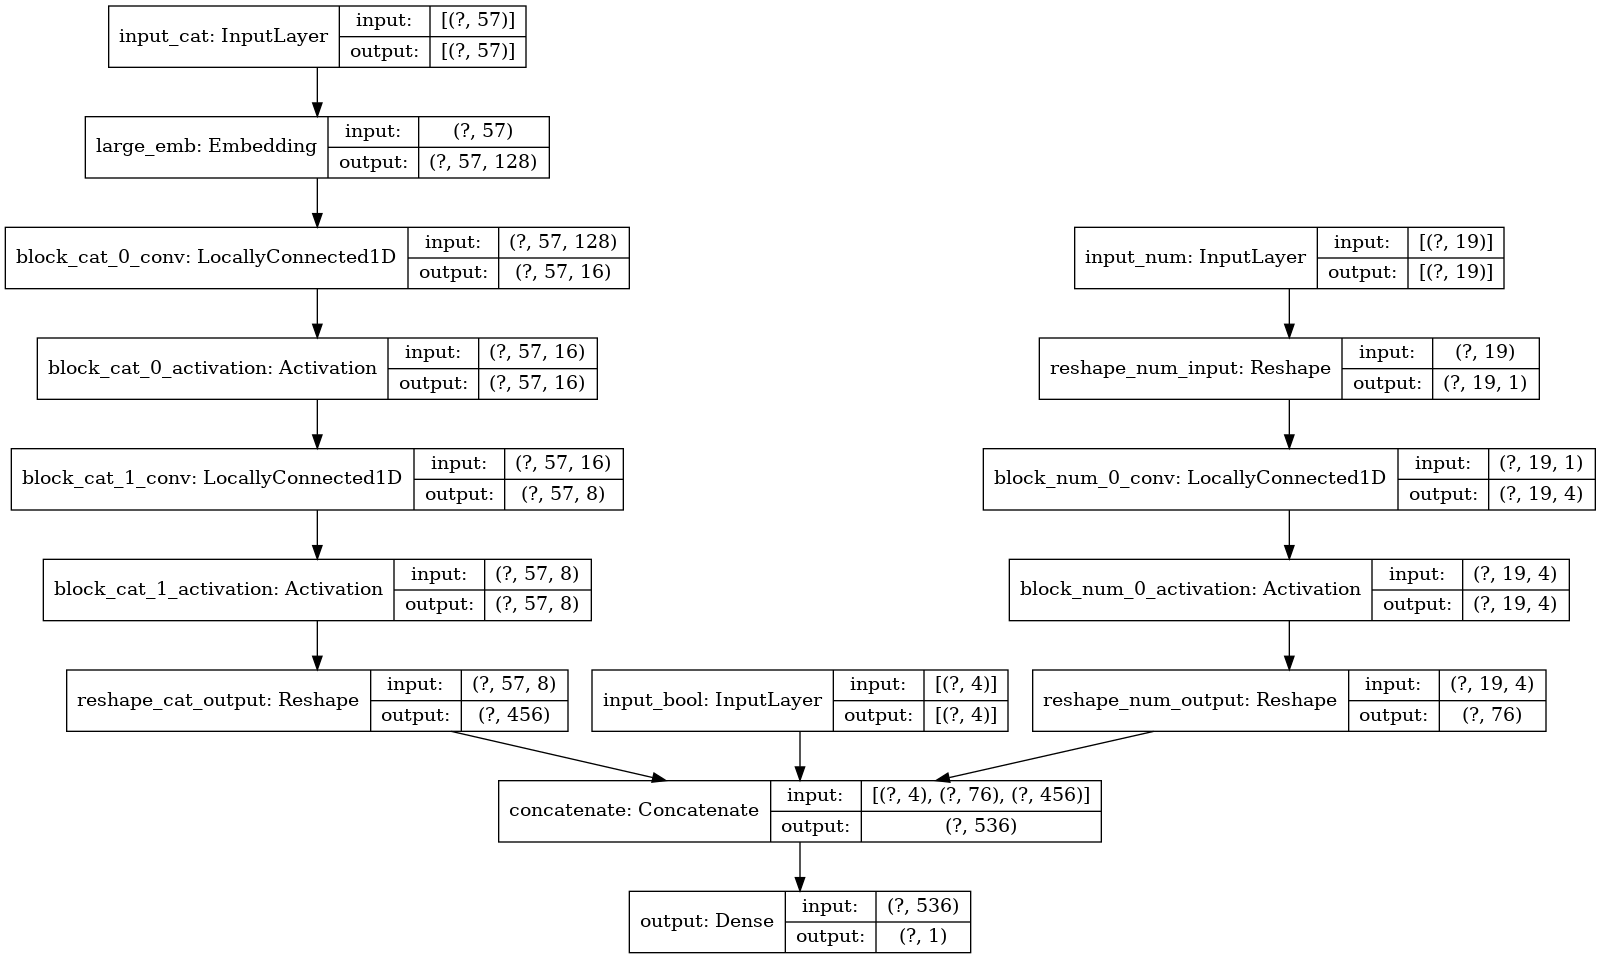

<IPython.core.display.Javascript object>

In [30]:
plot_model(
    model,
    # to_file="model.png",
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
)

In [31]:
y_train.shape

(1219, 1)

<IPython.core.display.Javascript object>

In [32]:
%%time
history = model.fit(
    input_train,
    y_train.reshape(-1, 1),
    epochs=2000,
    batch_size=8, #int(2**best_hp.values["batch_size"]),
    validation_data=(input_valid, y_valid.reshape(-1, 1),),
    verbose=2,
    callbacks=[EarlyStopping(monitor="val_loss", patience=20, verbose=1)],
#     class_weight=class_weight
)

Epoch 1/2000
153/153 - 1s - loss: 0.8698 - val_loss: 0.8679
Epoch 2/2000
153/153 - 1s - loss: 0.5639 - val_loss: 0.3141
Epoch 3/2000
153/153 - 1s - loss: 0.2774 - val_loss: 0.2188
Epoch 4/2000
153/153 - 1s - loss: 0.1939 - val_loss: 0.1981
Epoch 5/2000
153/153 - 1s - loss: 0.1577 - val_loss: 0.1988
Epoch 6/2000
153/153 - 1s - loss: 0.1391 - val_loss: 0.2121
Epoch 7/2000
153/153 - 1s - loss: 0.1287 - val_loss: 0.2155
Epoch 8/2000
153/153 - 1s - loss: 0.1176 - val_loss: 0.2267
Epoch 9/2000
153/153 - 1s - loss: 0.1112 - val_loss: 0.2294
Epoch 10/2000
153/153 - 1s - loss: 0.1079 - val_loss: 0.2441
Epoch 11/2000
153/153 - 1s - loss: 0.1048 - val_loss: 0.2555
Epoch 12/2000
153/153 - 1s - loss: 0.0993 - val_loss: 0.2563
Epoch 13/2000
153/153 - 1s - loss: 0.0963 - val_loss: 0.2733
Epoch 14/2000
153/153 - 1s - loss: 0.0948 - val_loss: 0.2838
Epoch 15/2000
153/153 - 1s - loss: 0.0929 - val_loss: 0.3428
Epoch 16/2000
153/153 - 1s - loss: 0.0916 - val_loss: 0.3376
Epoch 17/2000
153/153 - 1s - loss

<IPython.core.display.Javascript object>

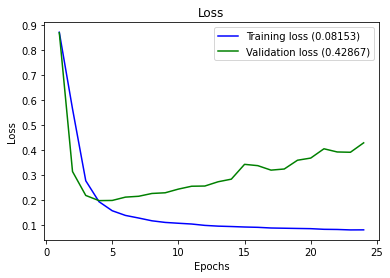

<IPython.core.display.Javascript object>

In [33]:
plot_history(history)

In [34]:
model_auc = mean_absolute_error(
    y_pred=target_encoder.inverse_transform(model.predict(input_valid)).reshape(-1),
    y_true=train[target].values[valid_indices],
)
model_auc

21151.086513157894

<IPython.core.display.Javascript object>

In [35]:
model_auc = mean_squared_error(
    y_pred=target_encoder.inverse_transform(model.predict(input_valid)).reshape(-1),
    y_true=train[target].values[valid_indices],
)
np.sqrt(model_auc)

51995.42211238393

<IPython.core.display.Javascript object>

In [36]:
model_auc = mean_absolute_error(
    y_pred=target_encoder.inverse_transform(model.predict(input_test)).reshape(-1),
    y_true=train[target].values[test_indices],
)
model_auc

19002.20162671233

<IPython.core.display.Javascript object>

In [37]:
model_auc = mean_squared_error(
    y_pred=target_encoder.inverse_transform(model.predict(input_test)).reshape(-1),
    y_true=train[target].values[test_indices],
)
np.sqrt(model_auc)

31761.08282828814

<IPython.core.display.Javascript object>

In [38]:
from xplainet.model import predict, encode

<IPython.core.display.Javascript object>

In [39]:
probs, explanations = predict(model, input_test)

<IPython.core.display.Javascript object>

In [40]:
probs, encoded_output = encode(model, input_test)

<IPython.core.display.Javascript object>

In [41]:
y_test.shape

(146, 1)

<IPython.core.display.Javascript object>

In [42]:
encoded_output.shape

(146, 536)

<IPython.core.display.Javascript object>

In [43]:
explanations.shape

(146, 80)

<IPython.core.display.Javascript object>

In [44]:
import matplotlib.pyplot as plt

# plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt


def explain_plot(importances, columns):
    selection = np.argsort(-np.absolute(importances))[:10]
    # indexes = np.argsort(importances)
    performance = importances[selection]
    #     print(performance.shape)512, 256, 128, 64, 32, 1
    y_pos = np.arange(performance.shape[0])

    plt.barh(y_pos, performance, align="center", alpha=0.5)
    plt.yticks(y_pos, columns[selection])
    # plt.xlabel('Usage')
    plt.title("Feature importance")

    plt.show()

<IPython.core.display.Javascript object>

In [45]:
all_cols = np.array(params["bool_cols"] + params["num_cols"] + params["cat_cols"])
all_cols

array(['Street', 'Alley', 'Utilities', 'CentralAir', '1stFlrSF',
       'BsmtUnfSF', 'YearRemodAdd', 'BsmtFinSF2', 'OpenPorchSF',
       'GarageYrBlt', 'GrLivArea', 'Id', 'LotFrontage', 'GarageArea',
       'LotArea', 'YearBuilt', 'BsmtFinSF1', 'ScreenPorch', 'MasVnrArea',
       'WoodDeckSF', '2ndFlrSF', 'TotalBsmtSF', 'EnclosedPorch',
       'SaleType', 'MasVnrType', 'YrSold', 'BsmtHalfBath', 'BedroomAbvGr',
       'GarageType', 'GarageFinish', 'Foundation', 'HouseStyle',
       'OverallQual', 'BsmtFinType1', 'FullBath', 'Fireplaces',
       'Condition2', 'Fence', 'HeatingQC', 'LotShape', 'MSZoning',
       'Exterior1st', 'BsmtExposure', 'Condition1', 'LandContour',
       'Functional', 'Heating', 'GarageCond', 'SaleCondition',
       'ExterCond', 'HalfBath', 'KitchenAbvGr', 'LandSlope',
       'Exterior2nd', 'MSSubClass', 'TotRmsAbvGrd', 'PoolQC',
       'OverallCond', 'RoofMatl', 'GarageQual', 'RoofStyle', 'PoolArea',
       'Neighborhood', 'Electrical', 'MiscFeature', 'LotConfig',

<IPython.core.display.Javascript object>

## Explain global

In [46]:
probs_train, explanations_train = predict(model, input_train)

<IPython.core.display.Javascript object>

In [47]:
global_explain = np.sum(explanations_train, axis=0)
global_explain = global_explain / np.abs(global_explain).sum()

<IPython.core.display.Javascript object>

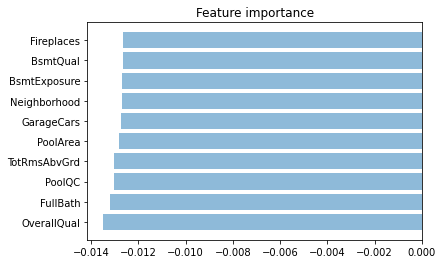

<IPython.core.display.Javascript object>

In [48]:
explain_plot(global_explain, all_cols)

In [49]:
global_explain = np.abs(explanations_train).sum(axis=0)
global_explain = global_explain / global_explain.sum()

<IPython.core.display.Javascript object>

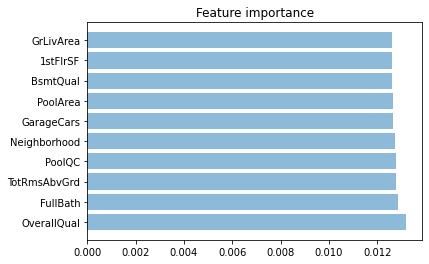

<IPython.core.display.Javascript object>

In [50]:
explain_plot(global_explain, all_cols)

In [51]:
global_explain = np.where(explanations_train >= 0, explanations_train, 0).sum(axis=0)
global_explain = global_explain / np.abs(global_explain).sum()

<IPython.core.display.Javascript object>

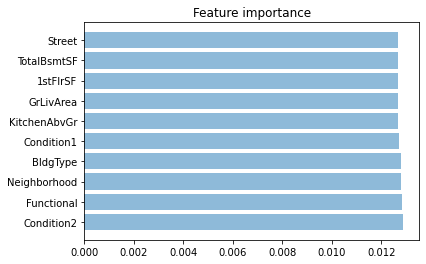

<IPython.core.display.Javascript object>

In [52]:
explain_plot(global_explain, all_cols)

In [53]:
global_explain = np.where(explanations_train < 0, explanations_train, 0).sum(axis=0)
global_explain = global_explain / np.abs(global_explain).sum()

<IPython.core.display.Javascript object>

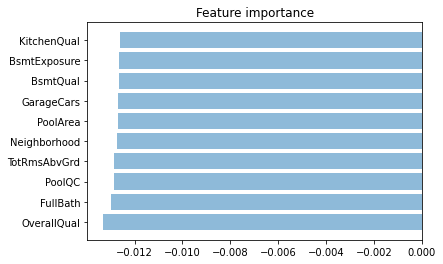

<IPython.core.display.Javascript object>

In [54]:
explain_plot(global_explain, all_cols)

## Explain local

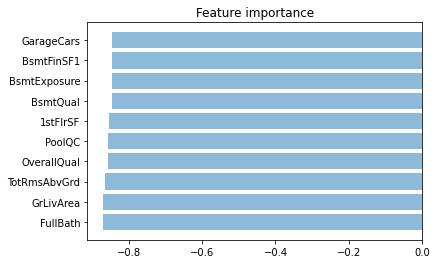

-0.4387606084346771


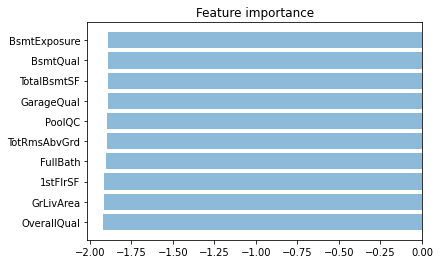

-1.7292346954345703


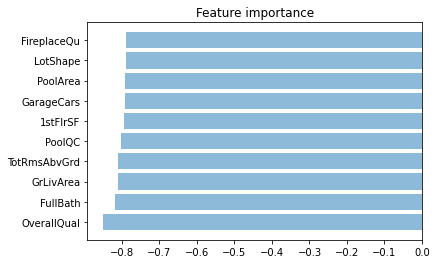

-0.3684629201889038


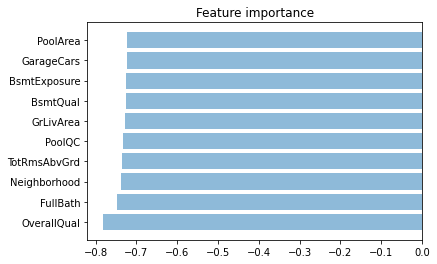

-0.2767813205718994


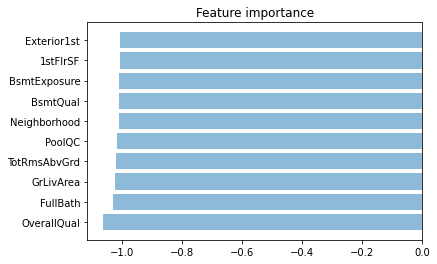

-0.653032660484314


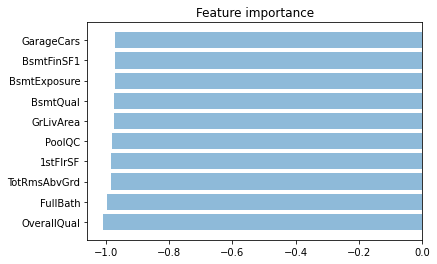

-0.6032187938690186


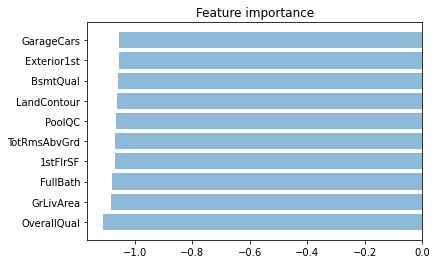

-0.7130149602890015


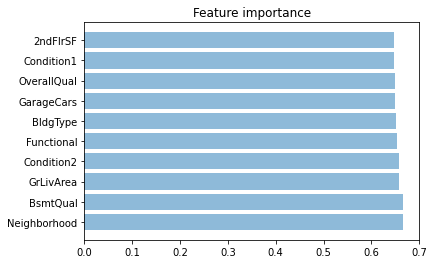

1.4410548210144043


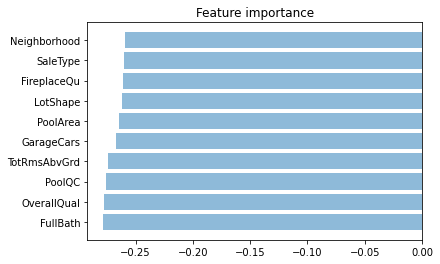

0.3316272795200348


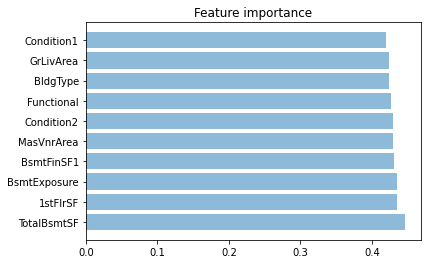

1.1624811887741089


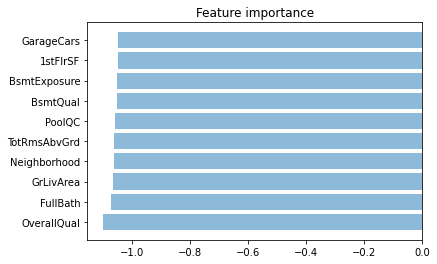

-0.7027386426925659


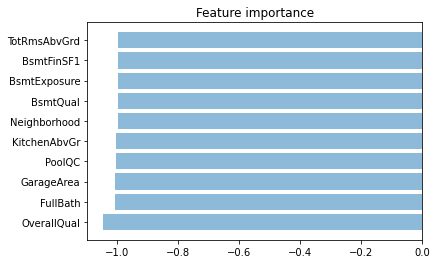

-0.6331858038902283


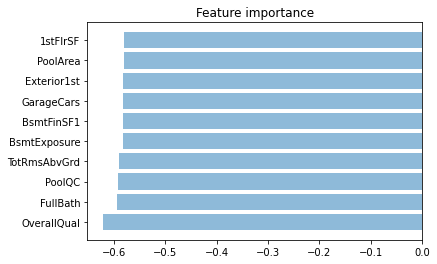

-0.08736347407102585


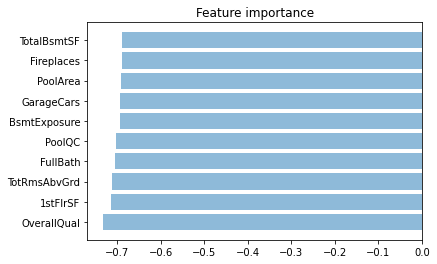

-0.23650076985359192


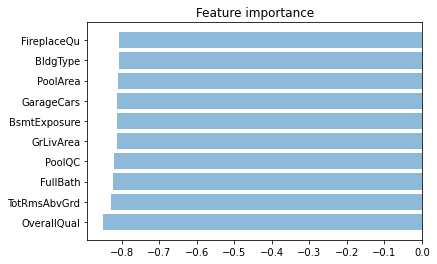

-0.391565203666687


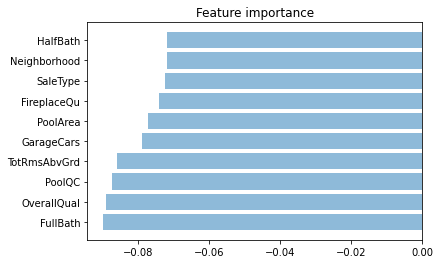

0.5766609907150269


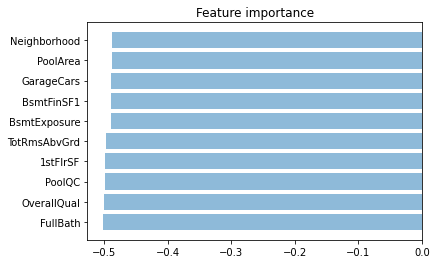

0.036304570734500885


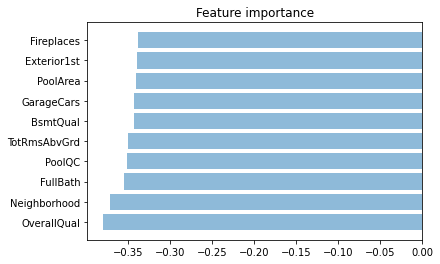

0.2316306233406067


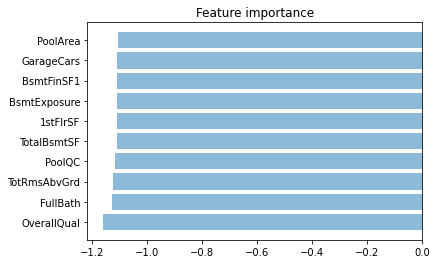

-0.7790572643280029


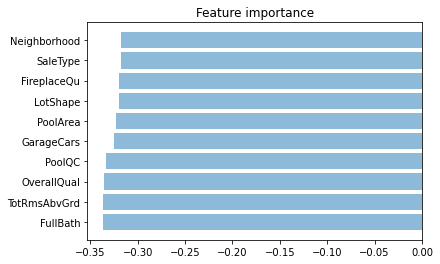

0.2553980052471161


<IPython.core.display.Javascript object>

In [55]:
for i in range(20):
    explain_plot(explanations[i], all_cols)
    print(probs[i].item())

In [56]:
from sklearn.metrics import confusion_matrix

<IPython.core.display.Javascript object>

In [57]:
probs_test, explanations_train = predict(model, input_test)

<IPython.core.display.Javascript object>

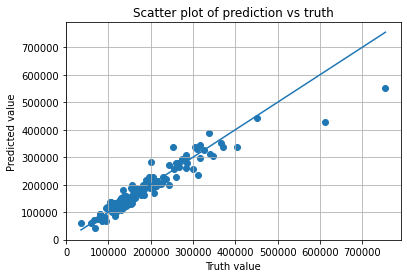

<IPython.core.display.Javascript object>

In [58]:
# plt.barh(y_pos, performance, align="center", alpha=0.5)
# plt.yticks(y_pos, columns[selection])
plt.ylabel("Predicted value")
plt.xlabel("Truth value")

plt.title("Scatter plot of prediction vs truth")
plt.scatter(
    train[target].values[test_indices],
    target_encoder.inverse_transform(probs_test),
)
plt.plot(
    [
        np.min(train[target].values[test_indices]),
        np.max(train[target].values[test_indices]),
    ],
    [
        np.min(train[target].values[test_indices]),
        np.max(train[target].values[test_indices]),
    ],
)
plt.grid(True)
plt.show()

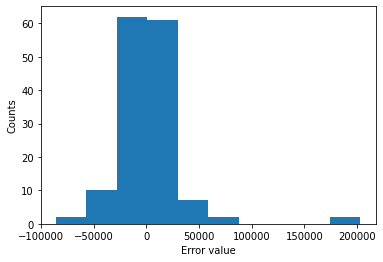

<IPython.core.display.Javascript object>

In [59]:
plt.hist(
    train[target].values[test_indices].reshape(-1)
    - target_encoder.inverse_transform(probs_test).reshape(-1),
)
plt.xlabel("Error value")
plt.ylabel("Counts")
plt.show()

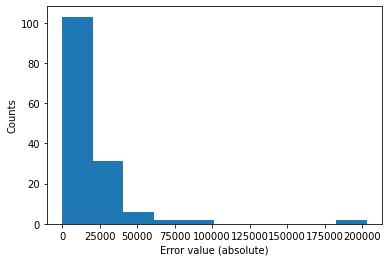

<IPython.core.display.Javascript object>

In [60]:
plt.hist(
    np.abs(
        train[target].values[test_indices].reshape(-1)
        - target_encoder.inverse_transform(probs_test).reshape(-1),
    )
)
plt.xlabel("Error value (absolute)")
plt.ylabel("Counts")
plt.show()

In [61]:
out = Path(os.getcwd() + "/data/" + dataset_name + "-test.csv")

<IPython.core.display.Javascript object>

In [62]:
kaggle_test = pd.read_csv(out, sep=",", low_memory=False)

<IPython.core.display.Javascript object>

In [63]:
input_kaggle, _ = preproc_dataset(kaggle_test, target, ["Set"], params)

<IPython.core.display.Javascript object>

In [64]:
probs_kaggle, _ = predict(model, input_kaggle)

<IPython.core.display.Javascript object>

In [65]:
probs_kaggle = target_encoder.inverse_transform(probs_kaggle)

<IPython.core.display.Javascript object>

In [66]:
probs_kaggle

array([[127059.04 ],
       [175503.69 ],
       [189233.06 ],
       ...,
       [186827.78 ],
       [124713.086],
       [212227.25 ]], dtype=float32)

<IPython.core.display.Javascript object>

In [67]:
test_df = kaggle_test[["Id"]]

<IPython.core.display.Javascript object>

In [68]:
test_df["SalePrice"] = probs_kaggle

/work/.cache/poetry/xplainet-KS9Ipbc1-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


<IPython.core.display.Javascript object>

In [69]:
test_df.to_csv("kaggle_submit.csv", index=False)

<IPython.core.display.Javascript object>

In [70]:
# Scores on kaggle
# https://www.kaggle.com/c/house-prices-advanced-regression-techniques/leaderboard#score
# 0.18047
# Batch size 16 + standard scaler
# 0.16028
# batch size 8
# 0.15498
# With tuner
# 0.15237
# with tuner, batch size 8
# 0.14499

# Next step should be with tuner on batch size ?

# Should train with RMSLE ?
# from tensorflow.keras import backend as K

# def root_mean_squared_log_error(y_true, y_pred):
#     return K.sqrt(K.mean(K.square(K.log(1+y_pred) - K.log(1+y_true))))

<IPython.core.display.Javascript object>